### Imports

In [1]:
import pandas as pd
import numpy as np

import os

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Load Data

Load csv.

Features are the emotions; the target variable is 'is_questionable'.

Ratain only users with at least one emotion.

Drop rows where "is_questionable" = NA.

In [2]:
ur_df = pd.read_csv('ur_usr_emo_lean.csv.gz').dropna().query('n_emo > 0')
ur_df

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,n_comments,n_words,len_text,appropriate,inappropriate,offensive,violent,leaning,is_questionable,id,n_emo
0,0.000000,0.10000,0.000000,0.200000,0.200000,0.300000,0.100000,0.300000,10,219,10,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,6
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,21,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,173,1
4,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1,9,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,175,5
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,2,24,2,0.500000,0.500000,0.000000,0.000000,0.000000,0.0,177,1
7,0.161290,0.16129,0.064516,0.129032,0.129032,0.258065,0.064516,0.129032,31,724,31,0.870968,0.000000,0.096774,0.032258,0.032258,0.0,178,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323999,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1,9,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,323621,3
324000,0.105263,0.00000,0.000000,0.105263,0.157895,0.210526,0.052632,0.263158,19,625,19,0.684211,0.000000,0.315789,0.000000,0.052632,0.0,323622,6
324002,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1,22,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,323624,2
324003,0.083333,0.25000,0.000000,0.166667,0.375000,0.041667,0.166667,0.458333,24,783,24,0.833333,0.041667,0.125000,0.000000,0.250000,0.0,323625,7


Besides the thresholds, the summary contains:
- Number of accounts
- The percentage of 'Questionable' accounts
- Number of 'Questionable' accounts
- Number of correctly classified 'Questionable' accounts
- Number of accounts classified as 'Questionable'
- Precision and Recall

As the minimum number of comments decrases, the proportion of Questionable accounts decreases too.
And so do precision and recall.
The number of emotions involved impacts much less on precision and recall than minimum number of comments

Browse the results directory and plot the bar and beeswarm plots for each experiment.

In [3]:
#for i in os.listdir():
    #print(i)
for i,dir in enumerate(os.listdir()):
    if os.path.isdir(dir):
        if dir == "plots":
            continue
        (min_comments, min_emo) = [int(dir.split('_')[i]) for i in [0,3] ]
        if min_emo == 1 and min_comments == 8:
            df = ur_df.query("n_comments >= @min_comments and n_emo >= @min_emo")
            #print(f'{len(df)=}')
            Y = np.where(df['is_questionable'].astype(int)>0,1,0)
            X = df[['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']]
            
            with open(str(os.path.join(dir,'shap.pkl')), 'rb') as f:
                my_shap_values = pkl.load(f)
            break


In [26]:
my_shap_values
feature_names = X.columns.str.capitalize()

rf_resultX = pd.DataFrame(X.values, columns = X.columns)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['Feature','Mean Absolute Feature Value'])
shap_importance.sort_values(by=['Mean Absolute Feature Value'],
                               ascending=False, inplace=True)

#shap_importance.to_csv('mean_abs_feature_importance_8com_1emo.csv', index=False)

In [5]:
shap_importance

,Feature,Mean Absolute Feature Value
7,Trust,0.229105
4,Joy,0.164088
5,Sadness,0.157711
3,Fear,0.140939
1,Anticipation,0.128546
0,Anger,0.099600
2,Disgust,0.081003
6,Surprise,0.071773


In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
w_high = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)
w_low = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


In [7]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def get_new_cmp(color01, color04):
    print(color01)
    print(color04)

    RGB_val = 255

    #color01 = (77, 146, 33)#color01= (0,150,200)  # Blue wanted
    #color04 = (197, 27, 125)#color04= (220,60,60)  # red wanted
    Colors = [color01, color04]

    # Creating a blue red palette transition for graphics
    Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
    n = 256

    # Start of the creation of the gradient
    Color01= ListedColormap(Colors[0], name='Color01', N=None)
    Color04= ListedColormap(Colors[1], name='Color04', N=None)
    top = cm.get_cmap(Color01,128)
    bottom = cm.get_cmap(Color04,128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                        bottom(np.linspace(0, 1, 128))))

    mymin0 = newcolors[0][0]
    mymin1 = newcolors[0][1]
    mymin2 = newcolors[0][2]
    mymin3 = newcolors[0][3]
    mymax0 = newcolors[255][0]
    mymax1 = newcolors[255][1]
    mymax2 = newcolors[255][2]
    mymax3 = newcolors[255][3]

    GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                    np.linspace(mymin1, mymax1,  n),
                    np.linspace(mymin2, mymax2,  n),
                    np.linspace(mymin3, mymax3,  n)]

    GradientBlueRed_res =np.transpose(GradientBlueRed)

    newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')
    return(newcmp)


In [8]:
#071a5d
w_high

ColorPicker(value='blue', description='Pick a color')

In [9]:
#cedfeb
w_low

ColorPicker(value='blue', description='Pick a color')

(206, 223, 235)
(7, 26, 93)


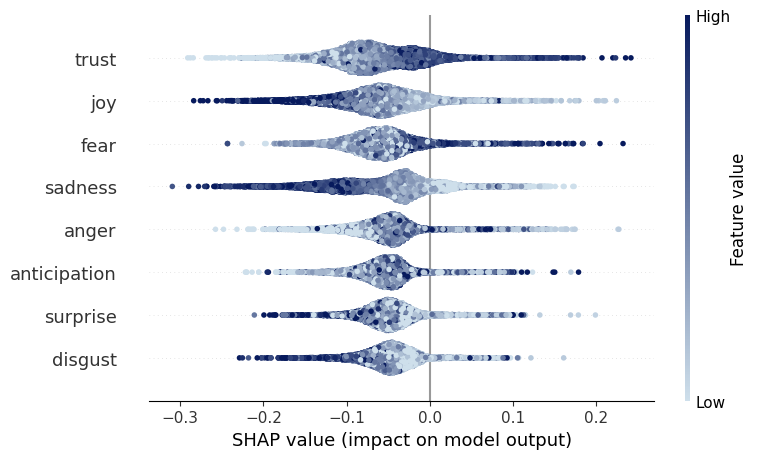

In [10]:
plt.figure()
shap.summary_plot(my_shap_values[1], X.values, feature_names = X.columns, show=False)
newcmp = get_new_cmp(hex_to_rgb(w_low.value), hex_to_rgb(w_high.value))
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
plt.savefig("shap_summary.pdf",dpi=300)
plt.savefig("shap_summary.png",dpi=300)

plt.show()


In [25]:
plot_importance = pd.DataFrame({'Feature':X.columns, 'Importance':np.sum(np.mean(np.abs(my_shap_values), axis=1), axis=0)})
print(np.sum(np.mean(np.abs(my_shap_values), axis=1), axis=0))
print(X.columns)
plot_importance.sort_values('Importance', ascending=False)
print(plot_importance)
plot_importance.to_csv('plot_importance.csv', index=False)

[0.11789621 0.11441608 0.10093169 0.12126505 0.13050642 0.11966711
 0.10433023 0.1364107 ]
Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust'],
      dtype='object')
        Feature  Importance
0         anger    0.117896
1  anticipation    0.114416
2       disgust    0.100932
3          fear    0.121265
4           joy    0.130506
5       sadness    0.119667
6      surprise    0.104330
7         trust    0.136411


In [33]:
print(np.sum(np.mean(np.abs(my_shap_values), axis=1), axis=0))
print(np.abs(my_shap_values[0]-my_shap_values[1]).mean(0))


[0.11789621 0.11441608 0.10093169 0.12126505 0.13050642 0.11966711
 0.10433023 0.1364107 ]
[0.11789621 0.11441608 0.10093169 0.12126505 0.13050642 0.11966711
 0.10433023 0.1364107 ]


In [92]:
import joblib

feat_importance_dict = {}
for i,dir in enumerate(os.listdir()):
    if os.path.isdir(dir):
        if dir == "plots":
            continue
        (min_comments, min_emo) = [int(dir.split('_')[i]) for i in [0,3] ]
        if min_comments == 8 and min_emo == 1:
            final_shap_model = joblib.load('/'.join([dir, "smote_model.joblib"]))    
        shap_model = joblib.load('/'.join([dir, "smote_model.joblib"]))
        perm_importance = pd.DataFrame({'Feature':shap_model.feature_names_in_, 'Importance':shap_model.feature_importances_})
        perm_importance.sort_values('Importance', ascending=False)
        if min_comments not in feat_importance_dict.keys():
            feat_importance_dict[min_comments] = {}
        feat_importance_dict[min_comments][min_emo] = perm_importance
final_shap_model


RandomForestClassifier(random_state=1518)

In [99]:
explainer = shap.TreeExplainer(final_shap_model)
explainer.shap_values

<bound method TreeExplainer.shap_values of <shap.explainers._tree.TreeExplainer object at 0x7fb1990d77c0>>

In [89]:
for min_comment in feat_importance_dict.keys():
    for min_emo in feat_importance_dict[min_comment].keys():
        perm_importance = feat_importance_dict[min_comment][min_emo]
        print(f'{min_comment= }')
        print(f'{min_emo= }')
        print(perm_importance.sort_values('Importance', ascending=False))

min_comment= 5
min_emo= 2
        Feature  Importance
7         trust    0.164068
4           joy    0.144808
3          fear    0.135186
5       sadness    0.127785
1  anticipation    0.123630
0         anger    0.112748
6      surprise    0.098852
2       disgust    0.092924
min_comment= 5
min_emo= 1
        Feature  Importance
7         trust    0.166531
4           joy    0.147572
3          fear    0.130456
5       sadness    0.128808
1  anticipation    0.122805
0         anger    0.111224
6      surprise    0.098985
2       disgust    0.093619
min_comment= 10
min_emo= 1
        Feature  Importance
7         trust    0.136151
0         anger    0.133283
4           joy    0.129695
3          fear    0.128217
5       sadness    0.124838
1  anticipation    0.123451
6      surprise    0.115505
2       disgust    0.108861
min_comment= 10
min_emo= 2
        Feature  Importance
7         trust    0.137345
0         anger    0.133230
4           joy    0.129982
3          fear    0.12690

In [44]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=150190)

#Augment the data points with SMOTE
over_X, over_Y = oversample.fit_resample(X, Y)


In [82]:

print(np.allclose(my_shap_values[0], -my_shap_values[1]))

True


(206, 223, 235)
(7, 26, 93)


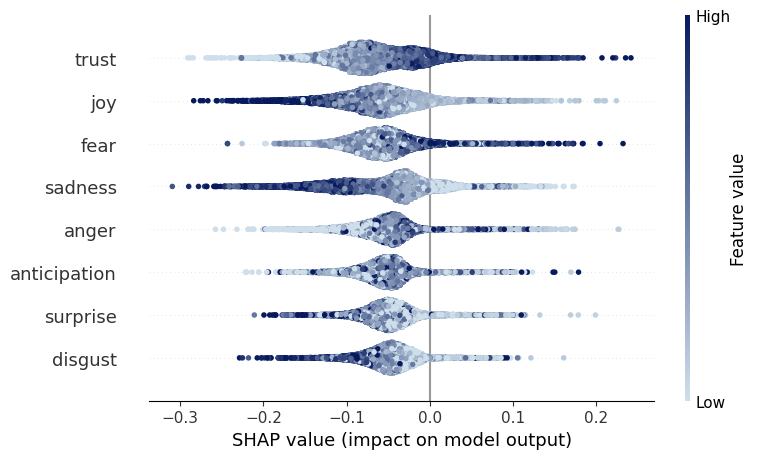

In [91]:
plt.figure()
shap.summary_plot(my_shap_values[1], X.values, feature_names = over_X.columns, show=False)
newcmp = get_new_cmp(hex_to_rgb(w_low.value), hex_to_rgb(w_high.value))
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
#plt.savefig("shap_summary.pdf",dpi=300)
#plt.savefig("shap_summary.png",dpi=300)

plt.show()

In [105]:
explainer = shap.TreeExplainer(final_shap_model, X)
shap_values = explainer(X)

 16%|===                 | 8039/50306 [04:33<23:55]       

In [ ]:
shap_values.abs.mean(0)

In [100]:
[['Trust','Anger','Fear','Joy','Surprise','Anticipation','Disgust'],
 ['Trust','Surprise','Anger','Joy','Fear','Sadness','Anticipation','Disgust'],
 ['Trust','Joy','Sadness','Fear','Anticipation','Anger','Disgust','Surprise'],
 ['Trust','Joy','Fear','Sadness','Anger','Anticipation','Surprise','Disgust'],
 ['Trust','Joy','Fear','Sadness','Anger','Anticipation','Surprise','Disgust'],
 ['Trust','Joy','Fear','Sadness','Anger','Anticipation','Surprise','Disgust']]

AttributeError: 'numpy.ndarray' object has no attribute 'abs'

In [31]:
for i,dir in enumerate(os.listdir()):
    if os.path.isdir(dir):
        print(dir)
        (min_comments, min_emo) = [int(dir.split('_')[i]) for i in [0,3] ]
        df = ur_df.query("n_comments >= @min_comments and n_emo >= @min_emo")
        Y = np.where(df['is_questionable'].astype(int)>0,1,0)
        X = df[['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']]
        
        try:
            with open(str(os.path.join(dir,'shap.pkl')), 'rb') as f:
                shap_values = pkl.load(f)
        except FileNotFoundError as e:
            print(e)
            continue
        
        
        clustering = shap.utils.hclust(X*100, Y*100)
        #shap.plots.bar(shap_values, clustering=clustering)
        
        shap.waterfall_plot(shap_values[0])
        #shap.summary_plot(shap_values,X.values, max_display=20,class_names= ['Reliable', 'Questionable'], feature_names = X.columns, show=True, clustering = clustering)
        #shap.bar_plot(shap_values,X.values, max_display=20, feature_names = X.columns, show=True, clustering = clustering)
        #shap.summary_plot(shap_values[1], X.values, feature_names = X.columns, show=True)
        #shap.summary_plot(shap_values[0], X.values, feature_names = X.columns, show=True)
        break

5_min_comments_2_min_emo_results
[Errno 2] No such file or directory: '5_min_comments_2_min_emo_results/shap.pkl'
10_min_comments_1_min_emo_results
[Errno 2] No such file or directory: '10_min_comments_1_min_emo_results/shap.pkl'
8_min_comments_2_min_emo_results
[Errno 2] No such file or directory: '8_min_comments_2_min_emo_results/shap.pkl'
5_min_comments_1_min_emo_results
[Errno 2] No such file or directory: '5_min_comments_1_min_emo_results/shap.pkl'
8_min_comments_1_min_emo_results


ModuleNotFoundError: No module named 'xgboost'